In [1]:
# Author: Nithin Purushothama

import numpy as np
import matplotlib.pyplot as plt

In [5]:
# ---------------------------
# Helper functions
# ---------------------------

def ideal_dac_output(code, N):
    bits = [(code >> k) & 1 for k in range(N)]
    return sum((2**k) * bits[k] for k in range(N))

def sample_dac_instance(N, sigma_unit, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    codes = np.arange(2**N)
    Iout = np.zeros_like(codes, dtype=float)
    bit_currents = np.zeros(N)
    for k in range(N):
        num_unit_cells = 2**k
        deltas = rng.normal(0.0, sigma_unit, size=num_unit_cells)
        bit_currents[k] = np.sum(1.0 + deltas)
    for code in codes:
        bits = [(code >> k) & 1 for k in range(N)]
        Iout[code] = sum(bit_currents[k] * bits[k] for k in range(N))
    return Iout

def compute_dnl_inl(Iout):
    steps = np.diff(Iout)
    ideal_step = np.mean(steps)
    DNL = (steps - ideal_step) / ideal_step
    codes = np.arange(len(Iout))
    ideal_line = Iout[0] + codes * ideal_step
    INL = (Iout - ideal_line) / ideal_step
    return DNL, INL

In [6]:
# ---------------------------
# Monte Carlo simulation
# ---------------------------

def run_monte_carlo(N=6, sigma_unit=0.02, num_runs=100, seed=None, show_plots=True):
    if seed is not None:
        np.random.seed(seed)

    codes = np.arange(2**N)
    ideal = np.array([ideal_dac_output(c, N) for c in codes])

    Iout_all = np.zeros((num_runs, len(codes)))
    DNL_all = np.zeros((num_runs, len(codes)-1))
    INL_all = np.zeros((num_runs, len(codes)))

    for run in range(num_runs):
        rng = np.random.default_rng()
        Iout = sample_dac_instance(N, sigma_unit, rng=rng)
        DNL, INL = compute_dnl_inl(Iout)
        Iout_all[run, :] = Iout
        DNL_all[run, :] = DNL
        INL_all[run, :] = INL

    results = {
        'Iout_all': Iout_all,
        'DNL_all': DNL_all,
        'INL_all': INL_all,
        'codes': codes,
        'ideal': ideal
    }

    if show_plots:
        plot_results(results, sigma_unit, num_runs)

    return results


In [7]:
# ---------------------------
# Plotting
# ---------------------------

def plot_results(results, sigma_unit, num_runs):
    Iout_all = results['Iout_all']
    DNL_all = results['DNL_all']
    INL_all = results['INL_all']
    codes = results['codes']
    ideal = results['ideal']

    # --- Ideal vs Example DAC ---
    plt.figure(figsize=(8,4))
    plt.step(codes, ideal, where='post', color='k', linewidth=2, label='Ideal')
    plt.step(codes, Iout_all[0,:], where='post', linestyle='--', label='Example run 0')
    plt.title('Ideal vs Example Mismatched DAC')
    plt.xlabel('Code')
    plt.ylabel('Iout / I0')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Compute mean & sigma per code across all runs ---
    DNL_sigma_vs_code = np.std(DNL_all, axis=0)
    INL_sigma_vs_code = np.std(INL_all, axis=0)
    DNL_mean_vs_code = np.mean(DNL_all, axis=0)
    INL_mean_vs_code = np.mean(INL_all, axis=0)

    # --- Plot σ(DNL) & σ(INL) vs code (with per-run traces + mean lines) ---
    plt.figure(figsize=(12,5))

    # ---- σ(DNL) vs Code ----
    ax1 = plt.subplot(1,2,1)
    # for run in range(num_runs):
        # ax1.plot(codes[1:], np.abs(DNL_all[run,:]), color='lightgray', alpha=0.4)
    ax1.plot(codes[1:], DNL_sigma_vs_code, color='tab:orange', marker='o', linewidth=2, label='σ(DNL)')
    ax1.plot(codes[1:], DNL_mean_vs_code, color='tab:red', linestyle='--', linewidth=2, label='Mean(DNL)')
    ax1.set_xlabel('Code')
    ax1.set_ylabel('[LSB]')
    ax1.set_title(f'σ(DNL) and Mean(DNL) vs Code ({num_runs} runs)')
    ax1.legend()
    ax1.grid(alpha=0.4)

    # ---- σ(INL) vs Code ----
    ax2 = plt.subplot(1,2,2)
    # for run in range(num_runs):
        # ax2.plot(codes, np.abs(INL_all[run,:]), color='lightgray', alpha=0.4)
    ax2.plot(codes, INL_sigma_vs_code, color='tab:green', marker='^', linewidth=2, label='σ(INL)')
    ax2.plot(codes, INL_mean_vs_code, color='tab:blue', linestyle='--', linewidth=2, label='Mean(INL)')
    ax2.set_xlabel('Code')
    ax2.set_ylabel('[LSB]')
    ax2.set_title(f'σ(INL) and Mean(INL) vs Code ({num_runs} runs)')
    ax2.legend()
    ax2.grid(alpha=0.4)

    plt.tight_layout()
    plt.show()

    print("Summary stats:")
    print(f"  Mean σ(DNL) over codes = {np.mean(DNL_sigma_vs_code):.5e} LSB")
    print(f"  Mean σ(INL) over codes = {np.mean(INL_sigma_vs_code):.5e} LSB")

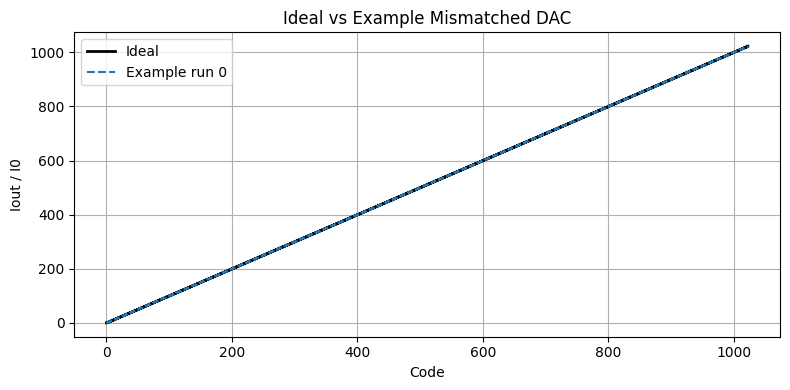

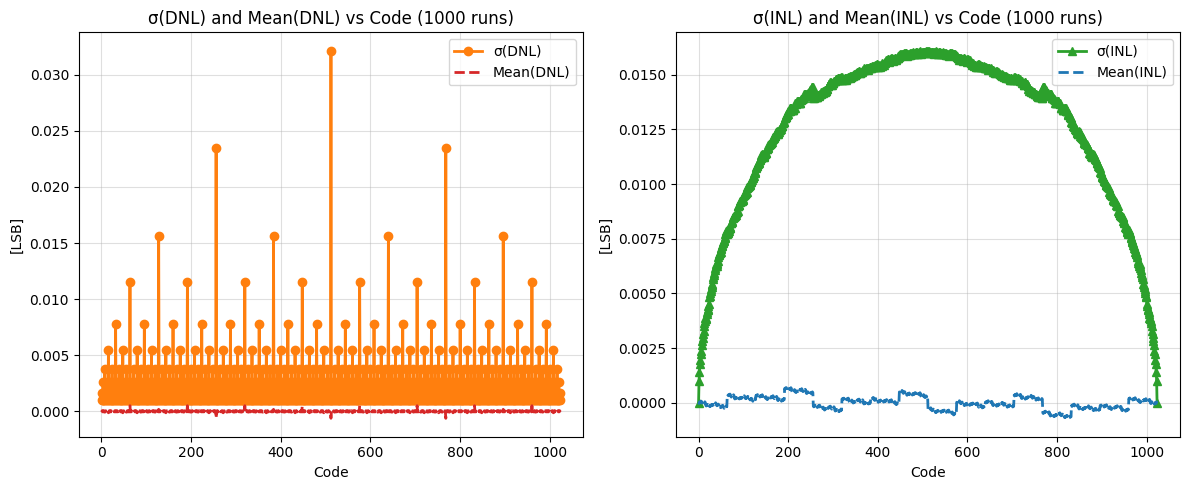

Summary stats:
  Mean σ(DNL) over codes = 2.01803e-03 LSB
  Mean σ(INL) over codes = 1.26248e-02 LSB


In [8]:

# ---------------------------
# Example usage
# ---------------------------
if __name__ == "__main__":
    N = 10
    sigma_unit = 0.001
    num_runs = 1000
    seed = 123
    results = run_monte_carlo(N=N, sigma_unit=sigma_unit, num_runs=num_runs, seed=seed, show_plots=True)